#### Summary:
In this notebook we'll add context to the coloc results and make plots for a few examples. At the end I have some example code for checking direction of SNP effect in both caQTLs and GWAS SNPs, which is important to do!

In [1]:
suppressMessages(library(vroom))
suppressMessages(library(data.table))
suppressMessages(library(coloc))
suppressMessages(library(stringr))
suppressMessages(library(tictoc))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(UpSetR))
suppressMessages(library(dplyr))

In [4]:
options(scipen=999)

In [5]:
theme_set(theme_classic())

In [6]:
links_dir <- '/dir/with/3methods/combined/links/fps'
caqtl_dir <- '/dir/with/caQTL/results'
outdir <- '/overall/dir/to/write/outputs/to'

In [7]:
#file paths to summary statistics
sumstats_dir <- '/dir/with/sumstats/files'
t1d_fp <- file.path(sumstats_dir,'T1D_meta_EARY_finns.all_chr.sumstats.txt')
t2d_fp <- file.path(sumstats_dir,'T2D_DIAMANTE.all_chrs_sumstats_hg38.txt.gz')
glu2h_fp <- file.path(sumstats_dir,'MAGIC1000G_2hGlu_EUR.all_chrs_sumstats_hg38.txt.gz')
fg_fp <- file.path(sumstats_dir,'MAGIC1000G_FG_EUR.all_chrs_sumstats_hg38.txt.gz')
fi_fp <- file.path(sumstats_dir,'MAGIC1000G_FI_EUR.all_chrs_sumstats_hg38.txt.gz')
hba1c_fp <- file.path(sumstats_dir,'MAGIC1000G_HbA1c_EUR.all_chrs_sumstats_hg38.txt.gz')

In [8]:
celltypes <- c('beta','alpha','delta','gamma','acinar','ductal','bulk')

In [9]:
major_colors = c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#FFA946', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 'stellate'='#AB7345',
                 'bulk'='#999999')

# 1. Collect links info for coloc features

In [106]:
celltype <- 'beta'

In [207]:
### Function so I can loop through cell types
get_linked_genes <- function(celltype, outdir){
    #read in final ppH4 features list and cut to cell type
    fp <- file.path(outdir,'all_ct_caQTL_features_all_GWAS_coloc.MAX_PROB_ppH4.txt')
    df <- read.table(fp, sep='\t', header=TRUE) %>%
            subset(caQTL_celltype==celltype) %>%
            select(-scenario,-GWAS_per_cre,-caQTL_celltype)

    #read in cRE-gene links summary file
    links_fp <- file.path(links_dir,sprintf('%s_all_methods_links.wHeader.bedpe',celltype))
    links <- read.table(links_fp, sep='\t', header=1)
    
    #map links to shorter peaks used in coloc
    map_fp <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/240304_union_peaks/celltype_union_peaks/%s.union_peaks.LINKS_MAP.bed',celltype)
    map <- read.table(map_fp, sep='\t')
    colnames(map) <- c('chr','start','end','chr1','start1','end1','union_peak')
    
    #map links cre coords to union peaks, clean up for merging
    links2 <- left_join(links, map, by=c('chr','start','end'))
    links2 <- links2 %>% mutate(cre=sprintf('%s:%s-%s',chr,start,end)) %>%
                relocate(cre) %>% 
                select(-c(chr,start,end,chr2,start2,end2)) %>% 
                mutate(union_cre=sprintf('%s:%s-%s',chr1,start1,end1)) %>%
                relocate(union_cre, .after=cre) %>%
                select(cre,union_cre,gene,method_str)

    #merge link info into coloc results
    df2 <- left_join(df, links2, by='cre') 
    print(table(is.na(df2$gene)))
    
    #write this to a file too
    out_fp <- file.path(outdir,sprintf('%s_caQTL_features_all_GWAS_coloc.MAX_PROB_ppH4.wLINKS_info.txt',celltype))
    write.table(df2, out_fp, sep='\t', row.names=F, quote=F)
}

In [208]:
for(celltype in celltypes[-7]){
    print(celltype)
    get_linked_genes(celltype,file.path(outdir,'ppH4_results'))
}

[1] "beta"

FALSE  TRUE 
  120    42 
[1] "alpha"

FALSE  TRUE 
   66    30 
[1] "delta"

FALSE  TRUE 
  118    21 
[1] "gamma"

FALSE  TRUE 
   90     2 
[1] "acinar"

FALSE  TRUE 
   70    18 
[1] "ductal"

FALSE  TRUE 
   10     8 


## Brief summary of coloc loci

In [237]:
#summarize how many unique loci coloc
fp <- file.path(outdir,'ppH4_results','all_ct_caQTL_features_all_GWAS_coloc.MAX_PROB_ppH4.txt')
df <- read.table(fp, sep='\t', header=1)

unique_loci <- subset(df, prob > 0.8) %>%
                mutate(cre_gwas=paste(cre,GWAS,sep='_')) %>%
                distinct(cre_gwas, .keep_all=TRUE)
dim(unique_loci)
head(unique_loci)

[1] 97  8

,cre,scenario,prob,caQTL_celltype,GWAS,celltypes_per_GWAS,GWAS_per_cre,cre_gwas
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1:206766274-206766841,ppH4,0.9872518,beta,T1D,"beta,alpha,bulk",T1D,chr1:206766274-206766841_T1D
2,chr17:47950496-47950755,ppH4,0.9287006,ductal,T1D,ductal,T1D,chr17:47950496-47950755_T1D
3,chr1:24970399-24970876,ppH4,0.8451056,bulk,T1D,"beta,bulk",T1D,chr1:24970399-24970876_T1D
4,chr1:229547647-229548225,ppH4,1.0000000,beta,T2D,beta,"T2D,FG",chr1:229547647-229548225_T2D
5,chr1:116971409-116973091,ppH4,0.9999714,beta,T2D,"beta,alpha,bulk",T2D,chr1:116971409-116973091_T2D
6,chr3:123346445-123348051,ppH4,0.9984318,beta,T2D,"beta,alpha,bulk",T2D,chr3:123346445-123348051_T2D


In [238]:
table(unique_loci$GWAS)


2hGlu    FG    FI HbA1c   T1D   T2D 
    3    24     7     8     3    52 

In [235]:
#summarize colocs with links!
all_res <- list()

for(celltype in celltypes[-7]){
    fp <- file.path(outdir,'ppH4_results',sprintf('%s_caQTL_features_all_GWAS_coloc.MAX_PROB_ppH4.wLINKS_info.txt',celltype))
    df <- read.table(fp, sep='\t', header=1)
    df2 <- subset(df, !is.na(method_str))
    df2$celltype <- celltype
    all_res[[celltype]] <- df2
}

res <- rbindlist(all_res)
unique_loci2 <- subset(res, prob > 0.8) %>%
                mutate(cre_gwas=paste(cre,GWAS,sep='_')) %>%
                distinct(cre_gwas, .keep_all=TRUE)
dim(unique_loci2)

[1] 41  9

# 2. Make comparison plots for loci of interest

## Functions

In [6]:
### Function to get allele freq for a subset of SNPs (listed in df)
get_af <- function(caqtl, feature){
    #read in chromosome vcf for SNPs within 100kb of a locus of interest
    chrom <- str_split(feature,':')[[1]][1]
    af_fp <- sprintf('/path/to/vcfs_peaks100kb/%s.ase.nofilt.vcf.gz',chrom)
    vcf <- suppressMessages(vroom::vroom(af_fp, skip=29))
    
    #cut down vcf to useful columns
    vcf2 <- vcf %>% select(ID, REF, ALT, INFO)
    colnames(vcf2) <- c('ID','Ref','Alt','Info')

    #merge with caQTL results
    snps <- merge(caqtl, vcf2, by.x=c('rsID','Ref','Alt'), by.y=c('ID','Ref','Alt'))

    #pull out MAF to Af column
    vcf_info <- as.data.frame(str_split_fixed(snps$Info, ';', 3))
    af <- as.numeric(gsub('AF=','',vcf_info$V1))
    return(af)
}

In [7]:
### Function to read in caQTL output file for a feature of interest
### feature should be written: chr#:start-end
read_caQTL <- function(feature, celltype, caqtl_dir){
    #read in matrixQTL output for the feature
    caqtl_fp <- file.path(caqtl_dir, celltype, sprintf('%s_Matrix_QTL_Results_100kb.tsv',feature))
    caqtl <- suppressMessages(vroom::vroom(caqtl_fp, show_col_types = FALSE))
    
    #modify columns
    #current cols: SNP	gene	beta	t-stat	p-value	FDR
    #needed cols: rsID, Feature, Chromosome, position, Alt, Ref, Af, Effect_size, P_VAl
    colnames(caqtl) <- c('rsID','Feature','Effect_size','T_stat','P_VAl','FDR')
    
    #extract other necessary info
    caqtl$ster <- caqtl$Effect_size/caqtl$T_stat
    
    #get alleles and maf
    snp_info <- as.data.frame(str_split_fixed(caqtl$rsID, ':', 4))
    colnames(snp_info) <- c('Chromosome','position','Ref','Alt')
    snp_info <- snp_info %>% mutate_at('position', as.numeric)
    fin_caqtl <- cbind(caqtl,snp_info)
    fin_caqtl$Af <- get_af(fin_caqtl, feature)
    
    return(fin_caqtl)
}

In [341]:
#make comparison plot for feature of interest
make_comp_plot <- function(x, gwas, gwas_prefix, celltype, lead_vars=NA){
    #get coloc data frame for feature
    feature <- read_caQTL(x, celltype, caqtl_dir)
    feature_name <- c(x)
    feature$chr_pos <- paste0(feature$Chromosome,':', feature$position)
    
    gwas_subset <- gwas[which(gwas$chr_pos %in% feature$chr_pos),]

    # CHECK IF ANY GWAS SNPS REMAIN AFTER SUBSETTING; IF NOT, SKIP COLOC
    if (dim(gwas_subset)[1] == 0){
        print(sprintf('No overlapping GWAS SNPs for feature: %s', x))
    } else {
        #These next 2 lines check that the alleles match in case the allele frequencies are in different format
        feature$alleles <- apply(feature[,c('Alt', 'Ref')], 1, function(x) paste(x[order(x)], collapse=''))
        gwas_subset$alleles <- apply(gwas_subset[,c('ALT', 'REF')], 1, function(x) paste(x[order(x)], collapse=''))

        #Coloc requires the 2 datasets to have all of the exact same SNPs, I do this by making a merged table
        m <- merge(gwas_subset,feature, by.x=c('CHR', 'POS', 'alleles'), by.y=c('Chromosome', 'position', 'alleles'))
        m <- m[!duplicated(m$SNPID)]

        #Checks allele frequency format, required to be in MAF (minor allele frequency)
        ##If not in MAF, will flip alleles and frequency so it will be MAF
        m$gwas_maf <- sapply(m$AF, function(x) min(c(x, 1-x)))
        m$gwas_flip <- m$AF < 0.5
        m$gwas_beta_alt <- m$BETA * (c(-1,1)[m$gwas_flip +1]) 
        m$caqtl_maf <- sapply(m$Af, function(x) min(c(x, 1-x)))
        m$caqtl_flip <- m$Af < 0.5
        m$caqtl_beta_alt <- m$Effect_size*(c(-1,1)[m$caqtl_flip +1]) 

        #Coloc has trouble if MAF is 0 or 1, remove those instances
        m <-m[!(m$gwas_maf == 0)]
        m <-m[!(m$AF == 0)]
        m <-m[!(m$caqtl_maf == 1)]
        m <-m[!(m$Af == 1)]
    }

    #coloc overlapping lead SNP
    m$color <- 'black'
    if(!is.na(lead_vars)){
        m$color[which(m$POS %in% lead_vars)] <- 'red'
    }     
    
    #also get cre coords
    cre_start <- as.numeric(str_split(str_split(cre,':')[[1]][2],'-')[[1]][1])
    cre_end <- as.numeric(str_split(str_split(cre,':')[[1]][2],'-')[[1]][2])

    #make plots
    p1 <- ggplot(m, aes(x=POS, y=-log10(P_VAl), fill=color)) + 
            geom_rect(aes(xmin=cre_start, xmax=cre_end, ymin=-Inf, ymax=Inf, alpha=0.2), color='grey', fill='grey') + 
            geom_point(size=3, alpha=0.7) + scale_fill_manual(values=c('black'='black','red'='red')) + 
            geom_vline(xintercept=lead_vars, color='red') + 
            ylab('-log10(caQTL pvalue)') + xlab('') + 
            theme(plot.title=element_text(hjust=0.5,size=25),
                  axis.title=element_text(size=20),
                  axis.text.y=element_text(size=15),
                  axis.text.x=element_text(size=15),
                  axis.ticks=element_blank(),
                  panel.grid.major=element_line(color='grey', size=0.5, linetype=2),
                  panel.border=element_rect(color='black',fill=NA, size=1),
                  legend.position='none')
    
    p2 <- ggplot(m, aes(x=POS, y=-log10(as.numeric(m$PVALUE)), color=color)) + 
            geom_rect(aes(xmin=cre_start, xmax=cre_end, ymin=-Inf, ymax=+Inf, alpha=0.2), color='grey', fill='grey') + 
            geom_point(size=3, alpha=0.7) + scale_color_manual(values=c('black'='black','red'='red')) + 
            geom_vline(xintercept=lead_vars, color='red') + 
            ylab('-log10(T2D pvalue)') + xlab('') + 
            theme(plot.title=element_text(hjust=0.5,size=25),
                   axis.title=element_text(size=20),
                   axis.text.y=element_text(size=15),
                   axis.text.x=element_text(size=15),
                   axis.ticks=element_blank(),
                   legend.position='none',
                   panel.grid.major=element_line(color='grey', size=0.5, linetype=2),
                   panel.border=element_rect(color='black',fill=NA, size=1))

    #combine into one fig
    options(repr.plot.height=12, repr.plot.width=12)
    theme_set(theme_classic())
    fig <- ggpubr::ggarrange(p1,p2,nrow=2)
    print(fig)
}

## Read in sumstats and plot

In [ ]:
gwas_prefix <- 'T2D'
gwas_fp <- t2d_fp

gwas <- fread(gwas_fp, header=TRUE)

# T2D modifications
gwas2 <- subset(gwas, CHR != 'X') %>%
        mutate(CHR2=paste0('chr',CHR)) %>% 
        select(-CHR, -chr) %>% 
        dplyr::rename(CHR=CHR2) %>% 
        relocate(CHR) %>%
        select(-POS) %>% 
        dplyr::rename(POS=pos_hg38) %>%
        dplyr::rename(REF=A2, ALT=A1, AF=FREQ1) %>%
        mutate(SNPID=paste(CHR,POS,REF,ALT,sep=':')) %>%
        select(-rsID,-SNP) %>%
        mutate(chr_pos=paste0(CHR,':',POS)) %>%
        mutate_at(c('PVALUE','AF'),as.numeric) 

Warning message in if (!is.na(lead_vars)) {:
“the condition has length > 1 and only the first element will be used”


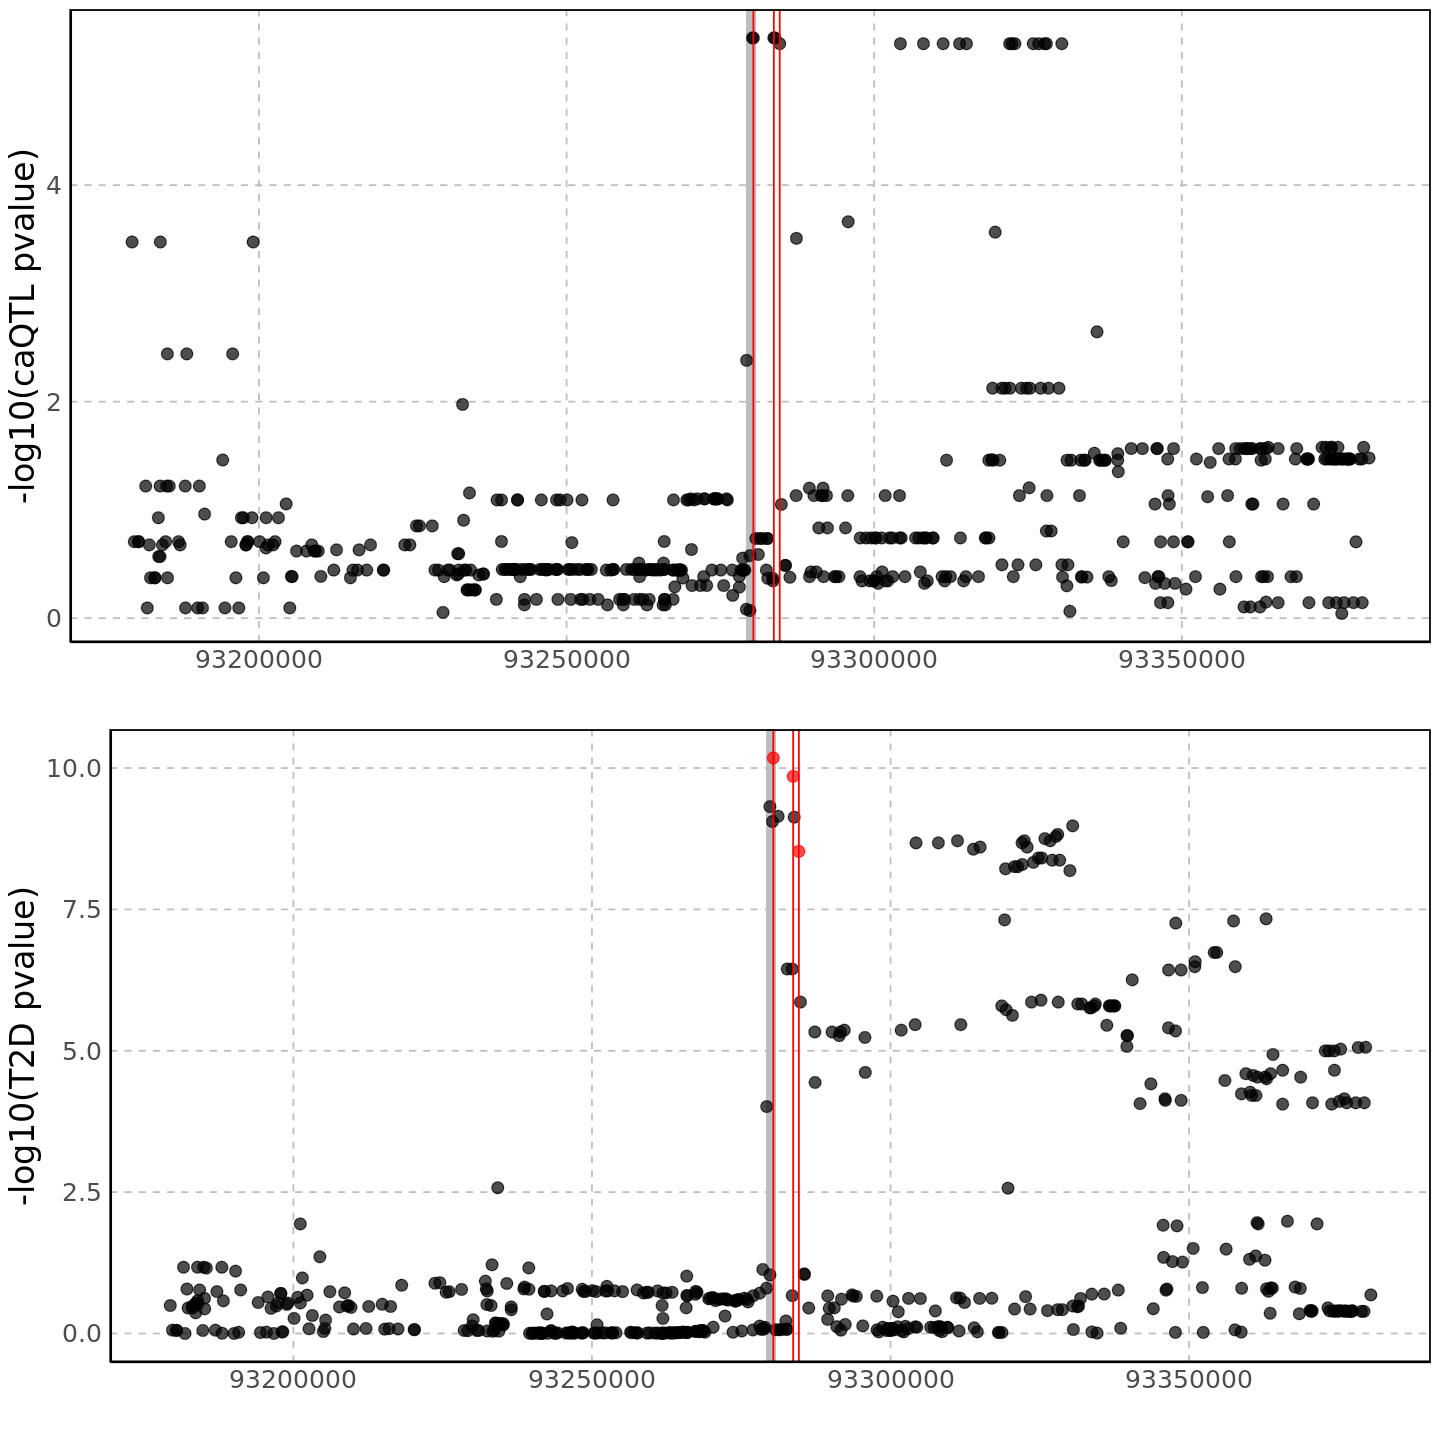

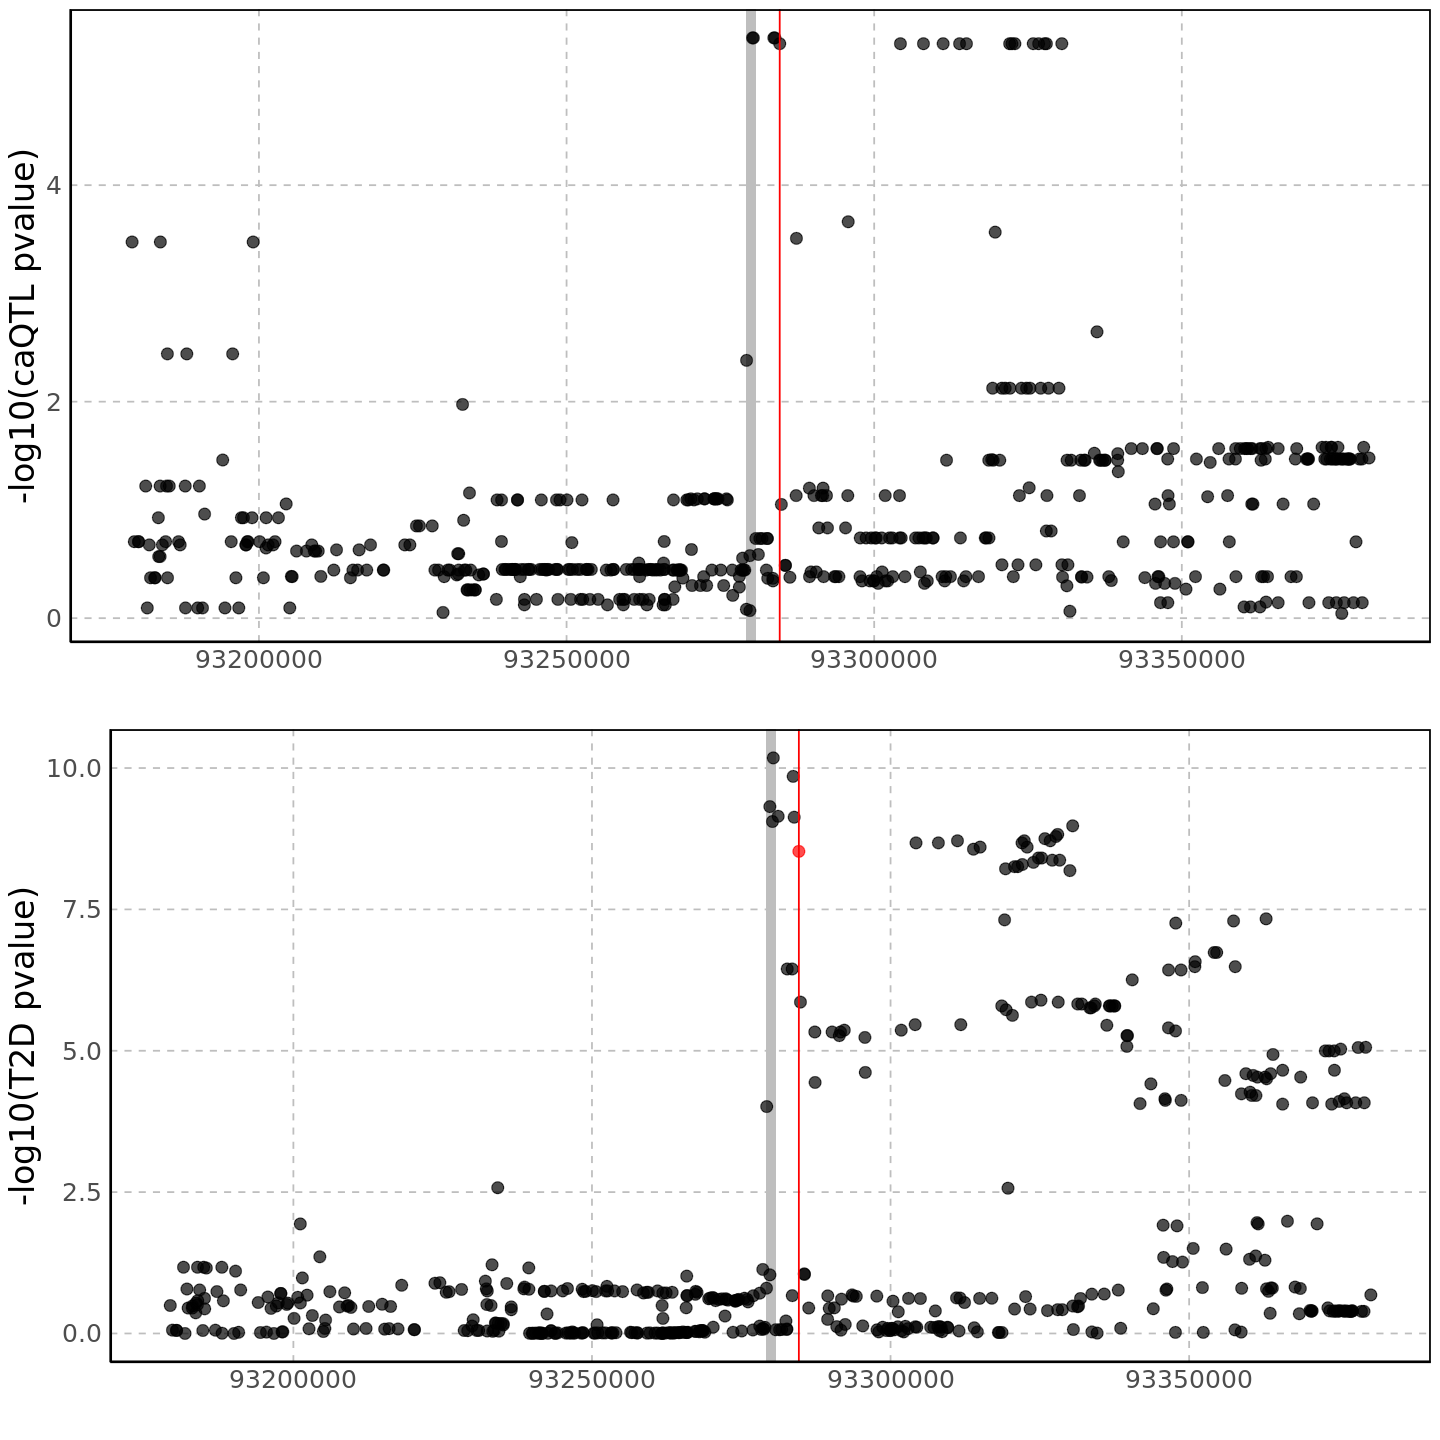

In [343]:
celltype <- 'beta'
cre <- 'chr11:93279349-93280568'

fig_dir <- '/nfs/lab/hmummey/multiomic_islet/figures/figure4'
fp <- file.path(fig_dir,sprintf('%s_caqtl_%s_T2D_coloc.svg',celltype, cre))
make_comp_plot(cre, gwas2, gwas_prefix, celltype, c(93280365,93283692,93284645))
make_comp_plot(cre, gwas2, gwas_prefix, celltype, c(93284645))

# 3. Check direction of effect of T2D variants!

## Example: DEUP1 coloc'd feature

In [57]:
#read back in basic coloc results with links info (not all the assocs for now)
fp <- file.path(outdir,sprintf('%s_caQTL_features_all_GWAS_coloc.MAX_PROB_ppH4.txt',celltype))
df <- read.table(fp, sep='\t', header=1)

cre <- 'chr11:93279349-93280568'
res <- subset(df, feature_name==cre)
res

,feature_name,scenario,prob,gwas
,<chr>,<chr>,<dbl>,<chr>
4,chr11:93279349-93280568,ppH4,0.9957838,T2D


In [60]:
#and read back in caQTL raw data and subset for the feature that was coloc'd
caqtl <- read_caQTL(cre, 'beta', caqtl_dir)

#now get window to search for credset in
min_bp <- min(caqtl$position)
max_bp <- max(caqtl$position)
chr <- unique(caqtl$Chromosome)
c(chr,min_bp,max_bp)

[1] "chr11"    "93269544" "93290216"

In [69]:
#read in T2D credible set at this locus
t2d_credset <- "path/to/credible/set/DIAMANTE_T2D.credset.hg38.bed"
credset <- fread(t2d_credset)
colnames(credset) <- c('CHR','START','POS','SNPID1','lead_var','strand','PPI')

#subset credset for the one overlapping the caQTL SNPs
locus <- unique(subset(credset, CHR==chr & POS >= min_bp & POS <= max_bp) %>% pull(lead_var))
locus
credset2 <- subset(credset, lead_var==locus)

#this doesn't have direction data so also need to combine with the sumstats (make sure these are read in as gwas)
gwas$chr_pos <- paste(gwas$CHR,gwas$POS,sep=':')
credset2 <- credset2 %>% mutate(chr_pos=paste(CHR,POS,sep=':')) %>% 
            select(-c(CHR,POS,SNPID1)) %>%
            dplyr::left_join(gwas, by='chr_pos')

#now clean it up a bit before combining with caQTL info
credset2 <- credset2 %>% select(CHR, POS, chr_pos, ALT, REF, AF, BETA, SE, N, PVALUE, PPI, lead_var, SNPID)

[1] "MTNR1B_11:93013531"

In [ ]:
#combine with caqtl info
caqtl <- caqtl %>% mutate(chr_pos=paste(Chromosome,position,sep=':'))
snps <- left_join(credset2, caqtl, by='chr_pos')
table(snps$REF==snps$Ref)
table(snps$ALT==snps$Alt)
snps %>% select(CHR, POS, REF, ALT, AF, BETA, Effect_size, PVALUE, P_VAl, PPI) %>%
        dplyr::rename(T2D_beta=BETA, caqtl_effect=Effect_size, GWAS_pval=PVALUE, caqtl_pval=P_VAl) %>%
        arrange(-PPI)

In [72]:
#-log10 transform P values for table
snps %>% mutate(log10_GWAS_p=-log10(PVALUE), log10_caQTL_p=-log10(P_VAl)) %>%
        select(CHR, POS, REF, ALT, AF, BETA, Effect_size, log10_GWAS_p, log10_caQTL_p, PPI) %>%
        dplyr::rename(T2D_beta=BETA, caqtl_effect=Effect_size, ) %>%
        arrange(-PPI)

CHR,POS,REF,ALT,AF,T2D_beta,caqtl_effect,log10_GWAS_p,log10_caQTL_p,PPI
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr11,93280365,C,T,0.2943,-0.0460,-1.006013,10.179208,5.360533,0.2452900
chr11,93283692,T,G,0.2945,-0.0452,-1.006013,9.852633,5.360533,0.1173700
chr11,93284645,A,G,0.7128,0.0418,1.004286,8.526367,5.307079,0.0634730
chr11,93280221,T,G,0.7188,0.0438,1.006013,9.054039,5.360533,0.0586480
chr11,93283860,C,T,0.2792,-0.0440,-1.006013,9.130592,5.360533,0.0513860
chr11,93401050,A,G,0.4247,0.0362,NA,7.718512,NA,0.0371450
chr11,93398501,C,A,0.4249,0.0361,NA,7.679438,NA,0.0340280
chr11,93330497,G,C,0.7270,0.0436,NA,8.977984,NA,0.0316880
chr11,93327993,T,C,0.7264,0.0432,NA,8.826231,NA,0.0219120


In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_1.0.10      UpSetR_1.4.0      ggpubr_0.5.0      ggplot2_3.4.4    
[5] tictoc_1.1        stringr_1.4.1     coloc_5.2.3       data.table_1.14.8
[9] vroom_1.5.7      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.13       lattice_0.20-45   tidyr_1.2